In [ ]:
!pip install yfinance
!pip install tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import itertools
from sklearn.preprocessing import StandardScaler      #Single-layer perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_regression, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import brute
from functools import partial

**Vortex** индикатор (VI)

> состоит из двух линий, которые показывают как положительное (VI +), так и отрицательное (VI -) движение тренда.


 Он был разработан Этьеном Боте и Дугласом Сипманом, авторов вдохновили определенные движения воды. У индикатора Vortex есть относительно простое и прямое применение: он используется трейдерами для определения начала тренда. Линию VI +, пересекающую линию VI (или ключевой уровень), можно рассматривать как бычий сигнал. Линия VI, пересекающая линию VI + (или ключевой уровень), может рассматриваться как медвежий сигнал. Это ключевые точки изменения тренда. Индикатор часто используется в сочетании с другими сигналами.

В работе реализован Vortex индикатор, гиперпараметр(период) подбирается с помощью оптимизации. Оптимизационная функция:

$$\sum_{i=1}^{D}(x_i-y_i)^2$$



In [ ]:

import pandas as pd
import yfinance as yf

# Загрузка исторических данных
ticker = 'AAPL' # Название компании
data = yf.download(ticker, start='2021-01-01', end='2021-12-31')
data



[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.164154,143301900
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.736374,97664900
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.402931,155088000
2021-01-07,128.360001,131.630005,127.860001,130.919998,128.647964,109578200
2021-01-08,132.429993,132.630005,130.229996,132.050003,129.758347,105158200
...,...,...,...,...,...,...
2021-12-23,175.850006,176.850006,175.270004,176.279999,174.288635,68356600
2021-12-27,177.089996,180.419998,177.070007,180.330002,178.292877,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,177.264633,79144300


In [ ]:
def eval(indicator_data):
  X= indicator_data[['Vortex+', 'Vortex-']]
  y= indicator_data['Close']

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
  reg = LinearRegression().fit(X_train, y_train)
  predict= reg.predict(X)
  mse=mean_squared_error(y,predict)
  return mse

In [ ]:
# Функция для расчета индикатора Vortex
def vortex_indicator(data, period):
  tr = abs(data['High'] - data['Low']).shift(1)
  trn = abs(data['High'] - data['Close'].shift(1))
  trp = abs(data['Low'] - data['Close'].shift(1))
  vm_plus = trn.rolling(period).sum() / tr.rolling(period).sum()
  vm_minus = trp.rolling(period).sum() / tr.rolling(period).sum()
  return pd.DataFrame({'Vortex+': vm_plus, 'Vortex-': vm_minus,'Close':data['Close']})

def objective_function(params, data, ):
  period = int(params[0])
  indicator_data = vortex_indicator(data, period)
  indicator_data=indicator_data.dropna()
  return  eval(indicator_data)

# Оптимизация гиперпараметров
param_ranges = (slice(1, 60, 1),) # Диапазон для параметра period
optimization_result = brute(partial(objective_function, data=data), param_ranges, full_output=True, finish=None)

best_period = int(optimization_result[0])
best_indicator_data = vortex_indicator(data, best_period)
print('Best period:', best_period)
best_indicator_data=best_indicator_data.set_index(data.index)

Best period: 49


In [ ]:
priod=optimization_result[2]
mse=optimization_result[3]

Text(0, 0.5, 'MSE')

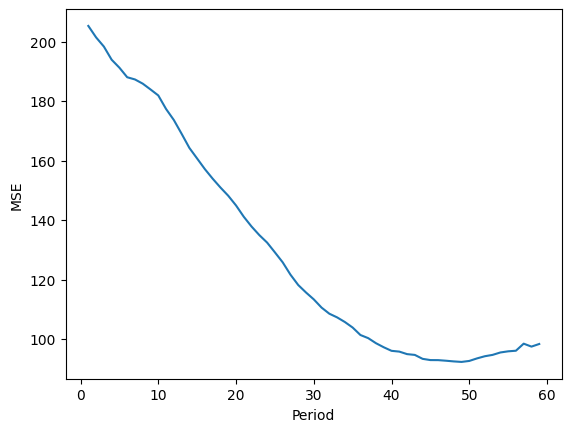

In [ ]:
plt.plot(priod,mse)
plt.xlabel('Period')
plt.ylabel('MSE')

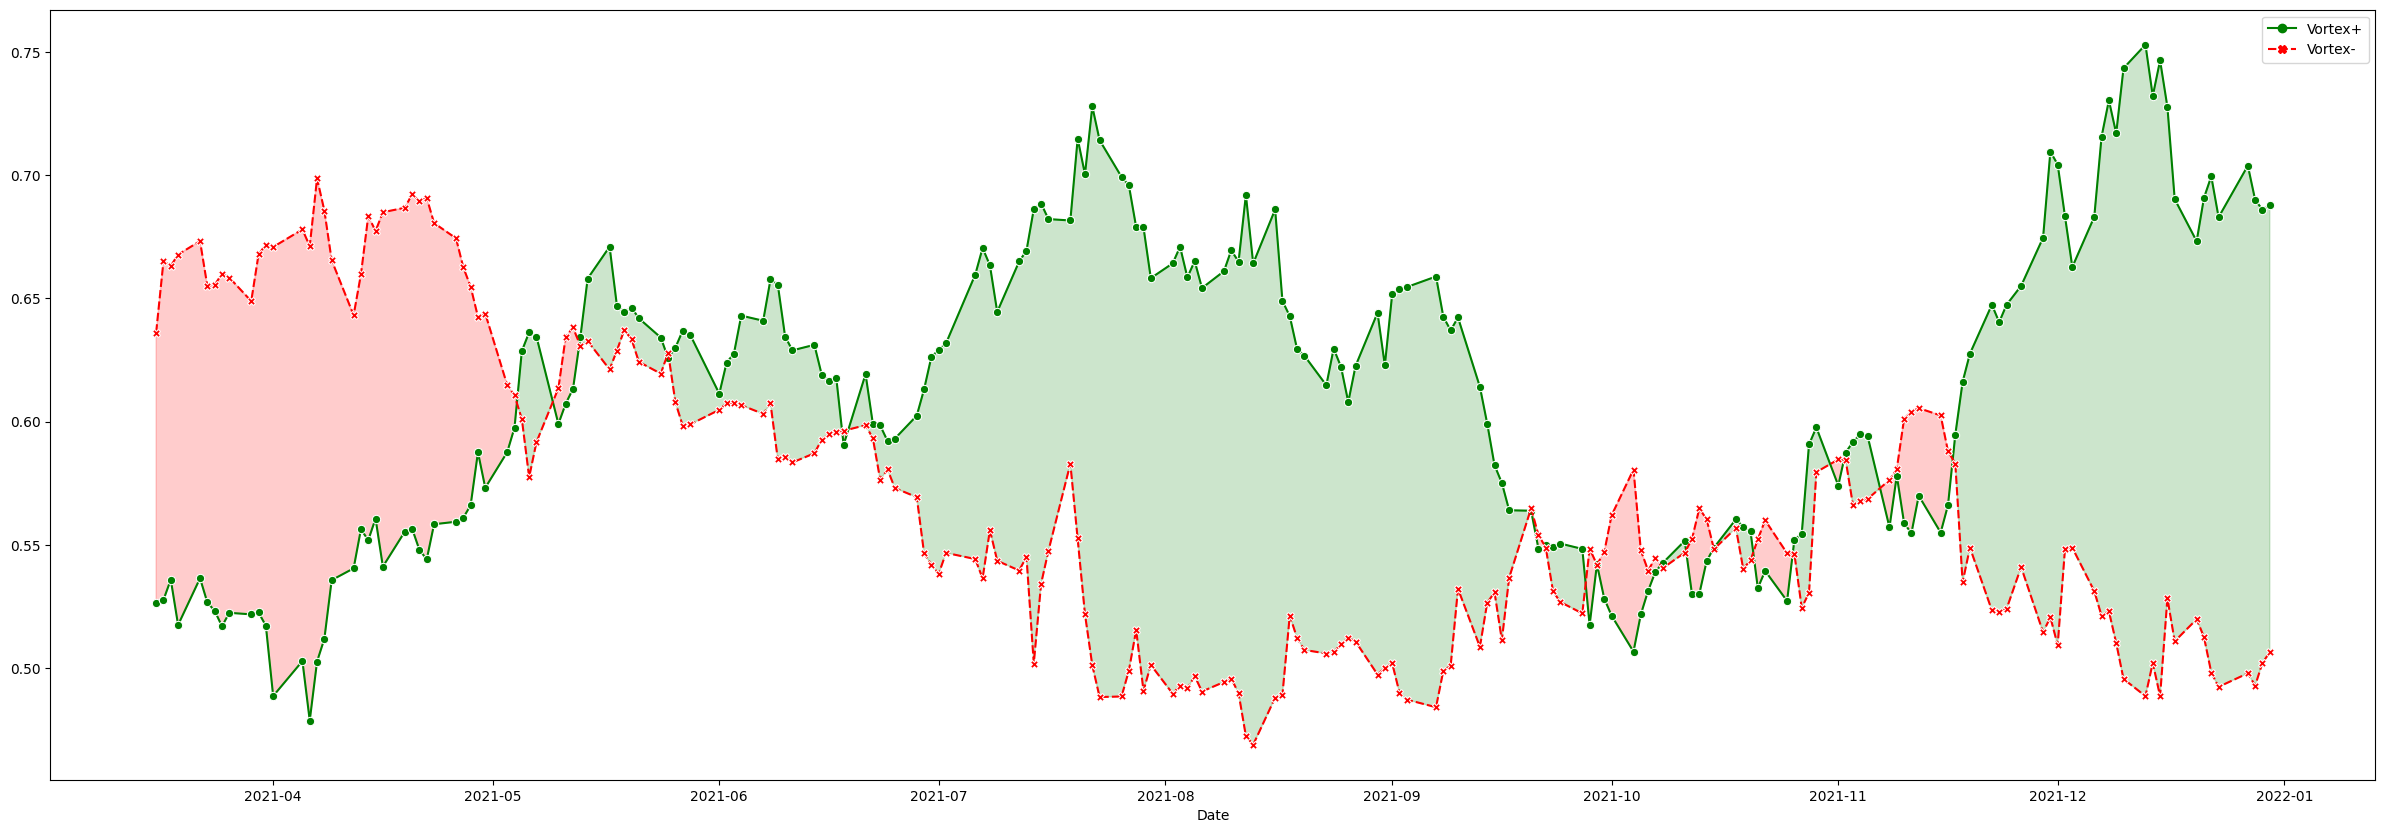

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
best_indicator_data=best_indicator_data.dropna()
sns.lineplot(data=best_indicator_data[['Vortex+','Vortex-']],markers=True , palette=['g','r'])
plt.fill_between(
    best_indicator_data.index,
    best_indicator_data['Vortex+'],
    best_indicator_data['Vortex-'],
    where= best_indicator_data['Vortex+']>=best_indicator_data['Vortex-'],
    alpha=0.2,
    color='g',
    interpolate=True)
plt.fill_between(
    best_indicator_data.index,
    best_indicator_data['Vortex-'],
    best_indicator_data['Vortex+'],
    where=  best_indicator_data['Vortex+']<best_indicator_data['Vortex-'],
    alpha=0.2,
    color='r',
    interpolate=True)

In [ ]:
def vortex_pred(date,best_indicator_data):
  try:
    if(best_indicator_data['Vortex+'].loc[date]>=best_indicator_data['Vortex-'].loc[date]):
      return 'Бычий рынок'
    else: return 'Медвежий рынок'
  except: return 'Период не найден'


In [ ]:
date='2021-03-19'
print(vortex_pred(date,best_indicator_data))

Медвежий рынок
